In [3]:
!pip install torch torchvision matplotlib numpy

In [4]:
!unzip helmet_classify_img.zip -d dataset

Archive:  helmet_classify_img.zip
   creating: dataset/helmet_classify_img/helmet/
  inflating: dataset/helmet_classify_img/helmet/0x0.jpg  
  inflating: dataset/helmet_classify_img/helmet/20211017_interesting-facts-about-the-design-and-use-of-motorcycle-helmets-scaled.jpg  
  inflating: dataset/helmet_classify_img/helmet/21936_jpg.rf.f0693848527a6a379793cce1391889e0.jpg  
  inflating: dataset/helmet_classify_img/helmet/22003_jpg.rf.3c23a6b5c5ba150f81a75e43bc5ecdc7.jpg  
  inflating: dataset/helmet_classify_img/helmet/22062_jpg.rf.0e5810ca6b1968802e0240d894704a56.jpg  
  inflating: dataset/helmet_classify_img/helmet/22086_jpg.rf.8c424f9599c686155584370a8d57d5cf.jpg  
  inflating: dataset/helmet_classify_img/helmet/22088_jpg.rf.f65011c58af100217efb18ccf461fd1a.jpg  
  inflating: dataset/helmet_classify_img/helmet/22095_jpg.rf.bd0a2569a75519bbe3ba86e0c1a8e9d7.jpg  
  inflating: dataset/helmet_classify_img/helmet/22112_jpg.rf.89ae411ec9ec03af0dc2ad9b9c787c3a.jpg  
  inflating: dataset/hel

In [5]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
from torch.utils.data import DataLoader, random_split, ConcatDataset

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Importing dataset

## Augmentations

In [7]:
aug_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=(0, 20)),
    v2.ColorJitter(brightness=.5, hue=.3),
    v2.RandomAutocontrast(),
    transforms.ToTensor()
])
org_transform = v2.Compose([
    v2.Resize((224, 224)),
    transforms.ToTensor()
])

In [8]:
data_path = "dataset/helmet_classify_img"
dataset = datasets.ImageFolder(root=data_path, transform=org_transform)
aug_ds = datasets.ImageFolder(root=data_path, transform=aug_transform)

### Concatenate original and augmented datasets

In [9]:
combined_dataset = ConcatDataset([dataset, aug_ds])

In [10]:
class_names = ["helmet", "no_helmet"]

In [11]:
def visualize_batch(batch):
    fig, ax = plt.subplots(ncols=5, figsize=(20, 20))
    for idx, im in enumerate(batch[0][:5]):
        im = im.numpy().transpose((1, 2, 0))
        ax[idx].imshow(im)
        ax[idx].title.set_text(batch[1][idx])

## Splitting data

In [12]:
val_size = 0.1
test_size = 0.2
val_len = int(val_size * len(combined_dataset))
test_len = int(test_size * len(combined_dataset))
train_len = len(combined_dataset) - val_len - test_len

In [13]:
train_set, val_set, test_set = random_split(combined_dataset, [train_len, val_len, test_len])

In [14]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [15]:
batch = next(iter(test_loader))
print(batch[0][0].shape)

torch.Size([3, 224, 224])


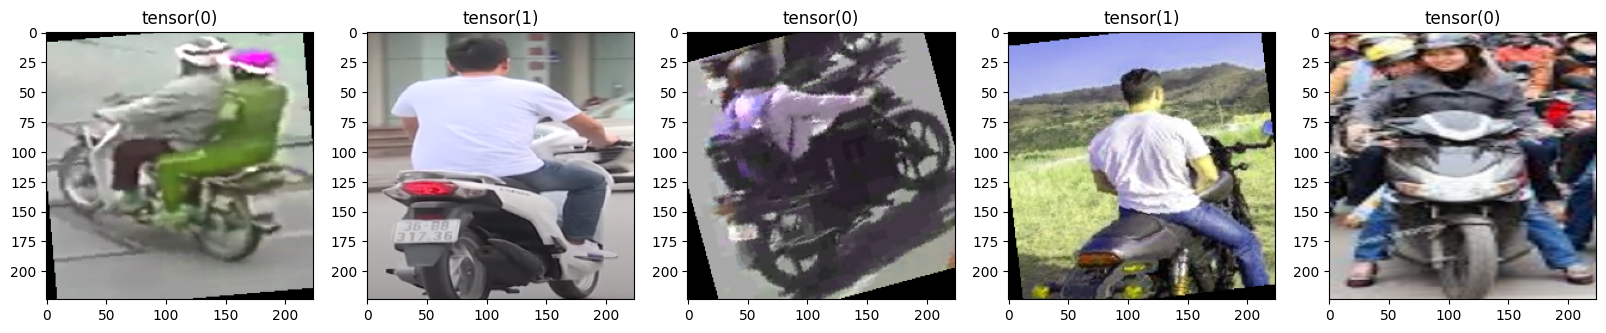

In [16]:
visualize_batch(batch)

In [30]:
len(test_loader)

5

# Models

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def report_model(model):
    model.eval()
    # Lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []
    # Testing loop
    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            true_labels.extend(labels.numpy())
            predicted_labels.extend(predicted.numpy())
    end_test_time = time.time()
    # Create a confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix
    class_names = ['helmet', 'no_helmet']
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    print(f"f1: {f1_score(true_labels, predicted_labels)}, precision: {precision_score(true_labels, predicted_labels)}, recall: {recall_score(true_labels, predicted_labels)}")
    print(f"Test reference time: {end_test_time - start_time} - Total examples: {len(test_set) * 32} - Avg: {(end_test_time - start_time) / (len(test_set) * 32)}")

In [24]:
num_classes = 2

### Googlenet - InceptionV1 (224x224)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


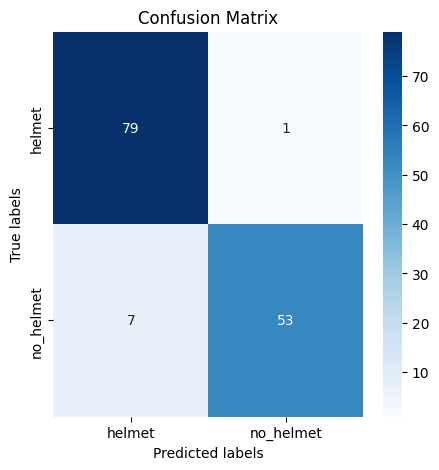

f1: 0.9298245614035088, precision: 0.9814814814814815, recall: 0.8833333333333333
Test reference time: 15.58468770980835 - Total examples: 4480 - Avg: 0.0034787249352250782


In [25]:
ggnet_model = models.googlenet(pretrained=True)
ggnet_model.fc = nn.Linear(ggnet_model.fc.in_features, num_classes)
ggnet_model.load_state_dict(torch.load('googlenet_finetuned.pth'))
report_model(ggnet_model)

### Mobilenet V2 (224x224)

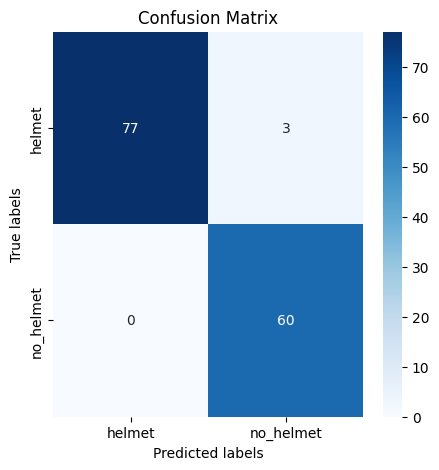

f1: 0.975609756097561, precision: 0.9523809523809523, recall: 1.0
Test reference time: 8.97815752029419 - Total examples: 4480 - Avg: 0.00200405301792281


In [27]:
mobilenet_model = models.mobilenet_v2(pretrained=True)
mobilenet_model.classifier[-1] = nn.Linear(mobilenet_model.classifier[-1].in_features, num_classes)
mobilenet_model.load_state_dict(torch.load('mobilenet_finetuned.pth'))
report_model(mobilenet_model)

### Shufflenet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:06<00:00, 1.39MB/s]


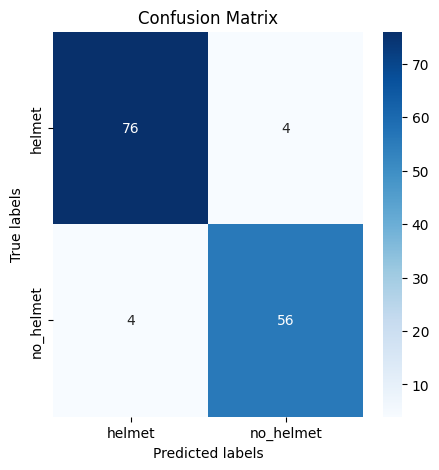

f1: 0.9333333333333333, precision: 0.9333333333333333, recall: 0.9333333333333333
Test reference time: 3.2385098934173584 - Total examples: 4480 - Avg: 0.0007228816726378032


In [28]:
shufflenet_model = models.shufflenet_v2_x1_0(pretrained=True)
shufflenet_model.fc = nn.Linear(shufflenet_model.fc.in_features, num_classes)
shufflenet_model.load_state_dict(torch.load('shufflenet_finetuned.pth'))
report_model(shufflenet_model)

### Squeezenet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 7.69MB/s]


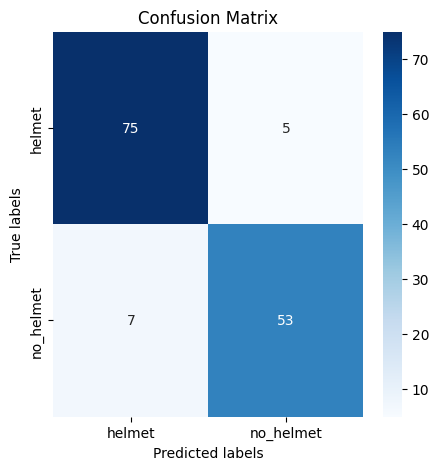

f1: 0.8983050847457628, precision: 0.9137931034482759, recall: 0.8833333333333333
Test reference time: 9.538521766662598 - Total examples: 4480 - Avg: 0.0021291343229157583


In [29]:
squeezenet_model = models.squeezenet1_0(pretrained=True)
squeezenet_model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
squeezenet_model.load_state_dict(torch.load('squeezenet_finetuned.pth'))
report_model(squeezenet_model)